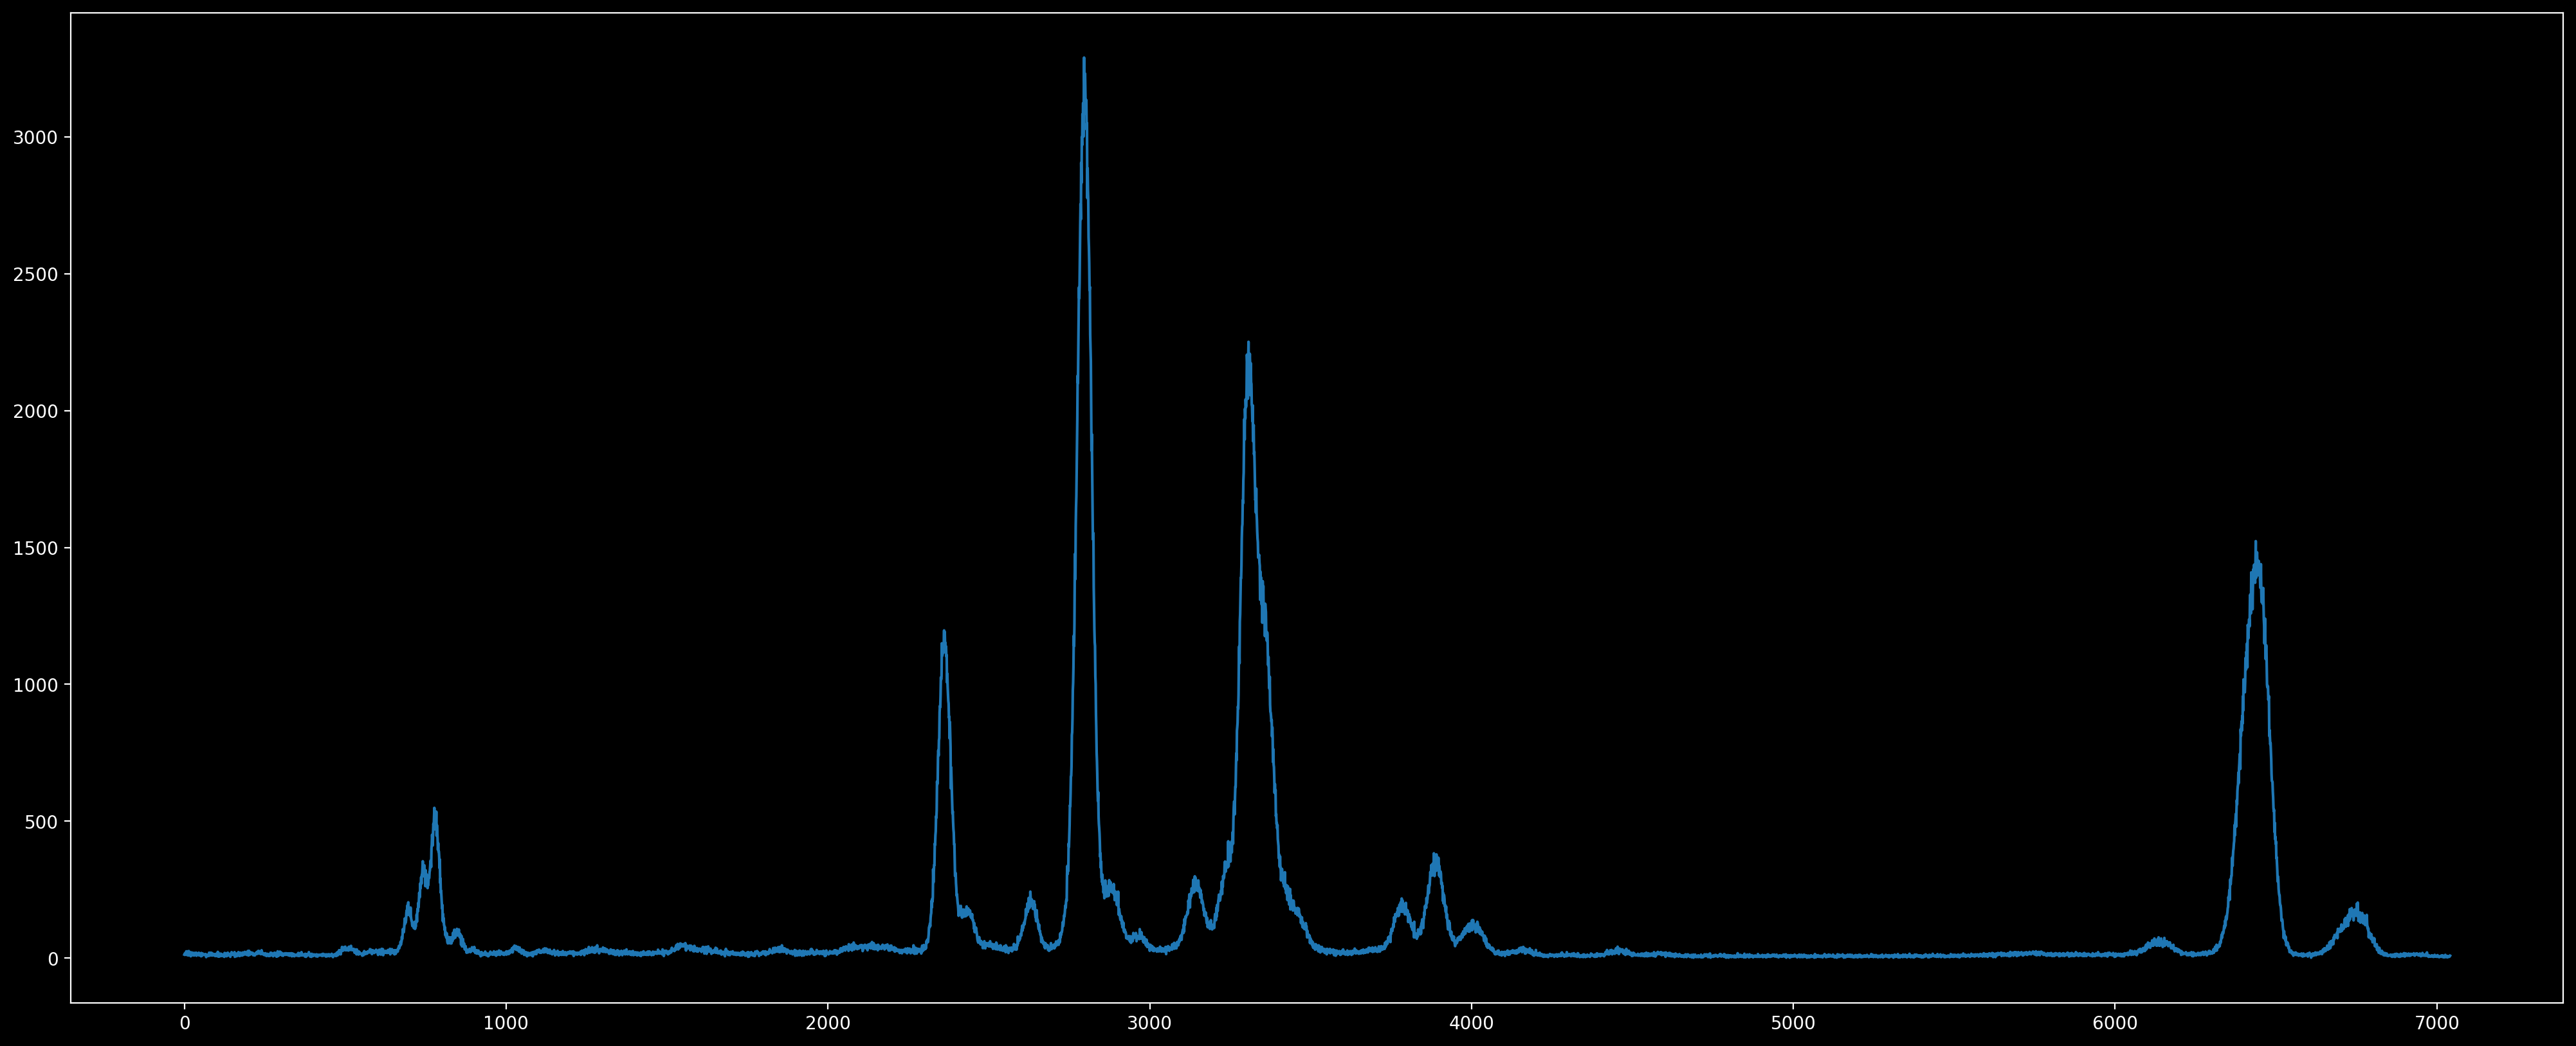

In [22]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import ExponentialModel, GaussianModel

import statistics


sciezka="./"
#sciezka="./dr-t/"
#sciezka="./15/proszek/"
#sciezka="./15/skaêa/"

nr_pliku=sciezka+"p1b"+".mca"

a=0
q=[]
accu_t=[]
dead_t=[]
with open(nr_pliku,'r', encoding='utf-8',
                 errors='ignore') as infile:
    for line in infile:
        #print(a)
        a=a+1
if a==8275:
    b=0 #jesli nie ma ROI
if a==8277:
    b=2 #jesli jest ROI
    
a=0
q=[]
accu_t=[]
dead_t=[]
with open(nr_pliku,'r', encoding='utf-8',
                 errors='ignore') as infile:
    for line in infile:
        #print(a)
        a=a+1
        if a==8269+b:
            #print(line, end='') 
            line=line.strip('\n')
            line=float(line[18:])
            accu_t.append(line) 
        if a==8271+b:
            #print(line, end='') 
            line=line.strip('\n')
            line=line.strip('%')
            line=float(line[11:])
            dead_t.append(line) 

        if a>12+b and a<8205+b:
            #print(line, end='') 
            line=line.strip('\n')
            q.append(line) 
w = list(map(int, q))

wx=w[1150:]
x = np.arange(0, len(wx))
plt.figure(figsize=(25, 10))
plt.plot(x, wx)
plt.show()

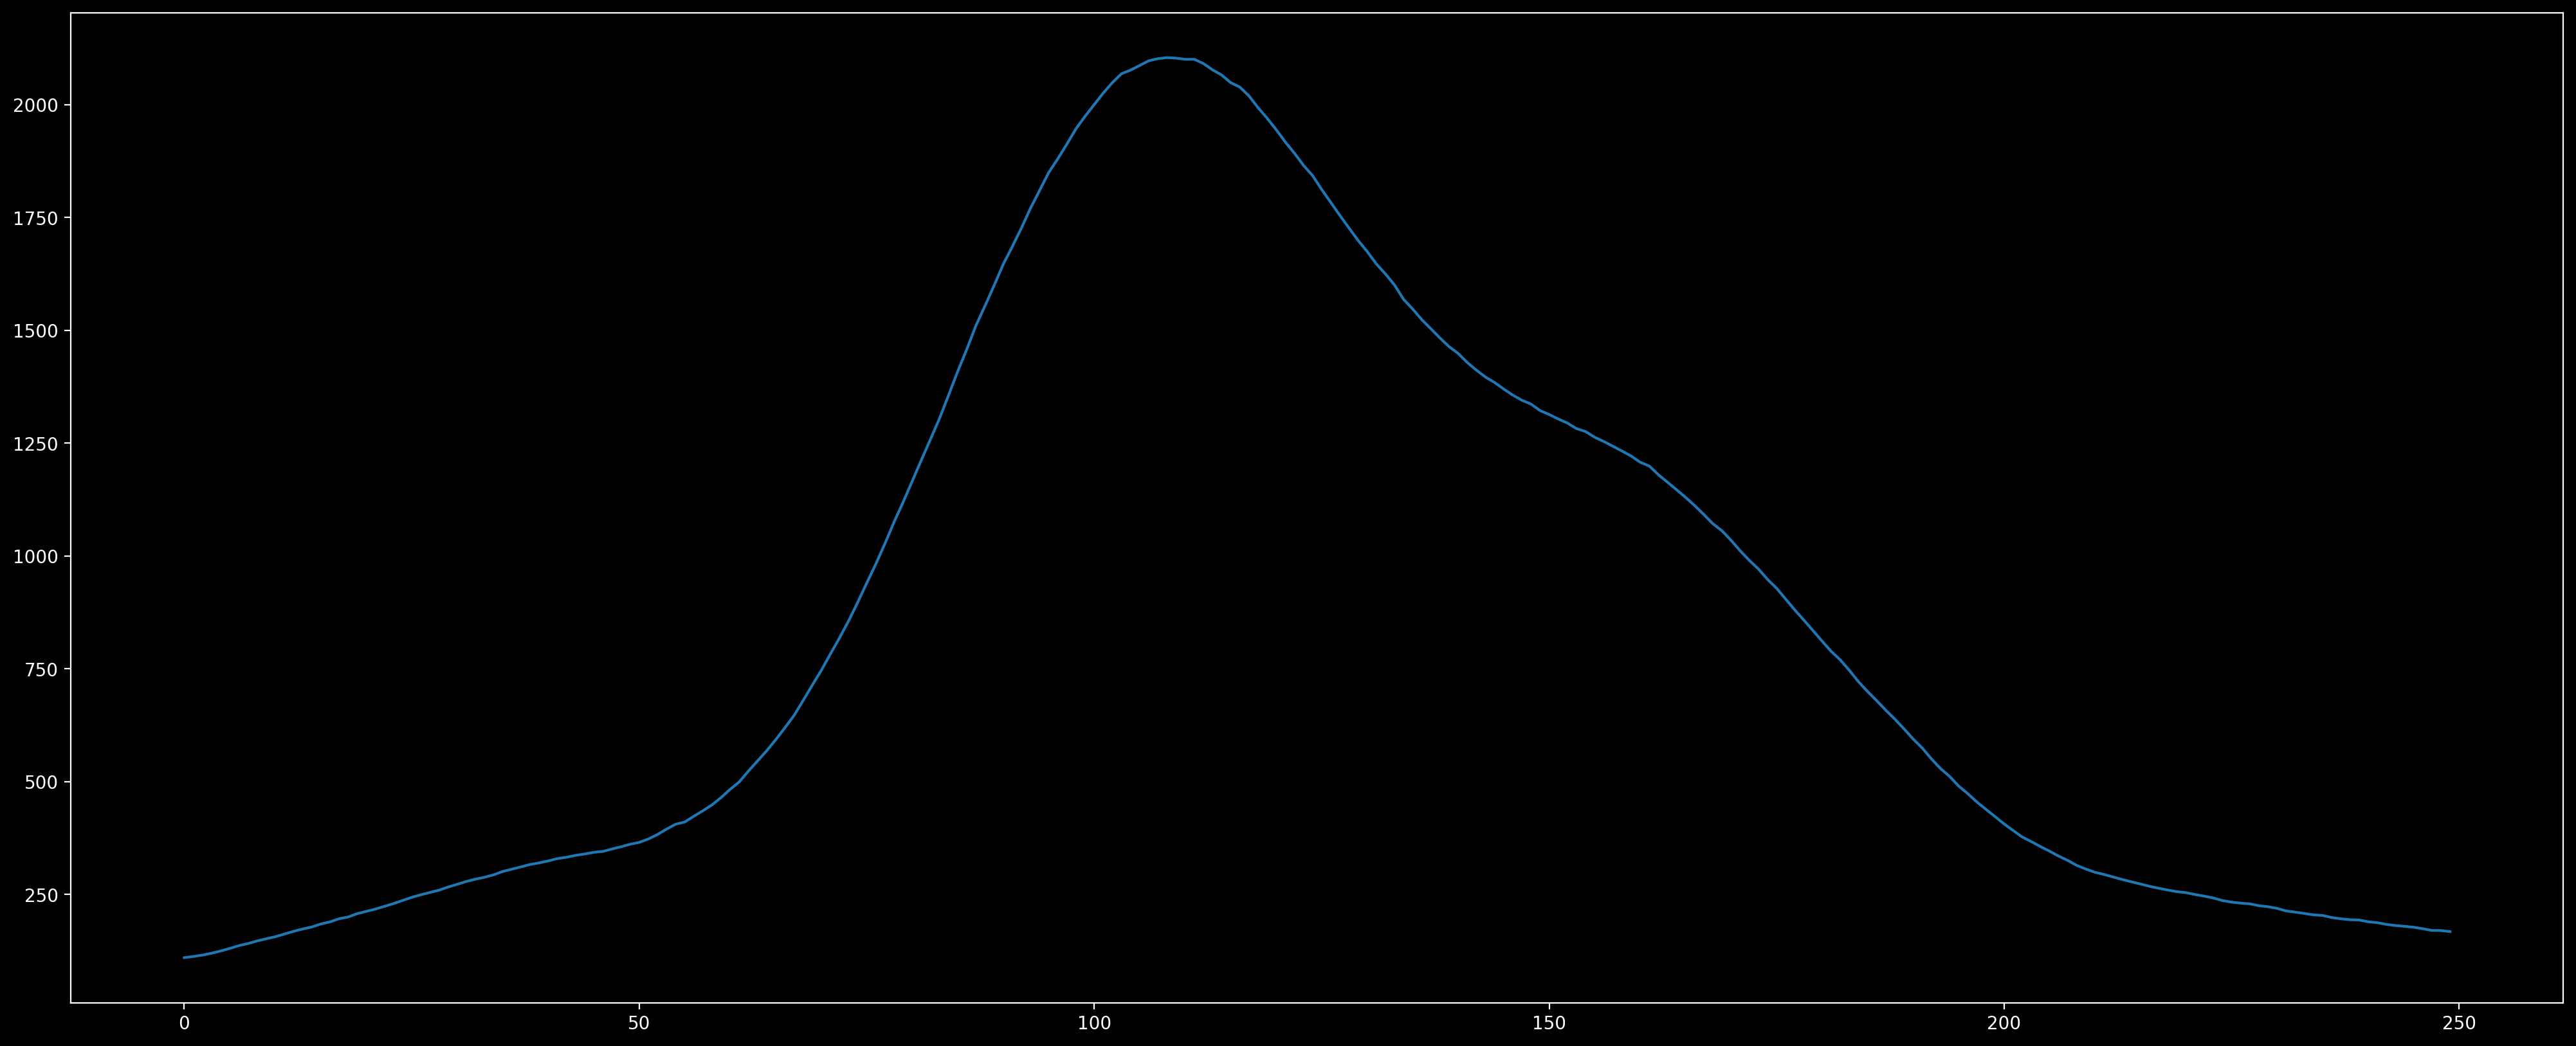

250
125.0
2103.9389550097153


In [23]:
smooth_val=20
x = range(len(wx))
y = wx
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
wx=smooth(y,smooth_val)

def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z
def plt_legend_out(frameon=True):
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=frameon)
x = range(len(wx))
y = wx

spectra = wx[:]
baseline = baseline_als(spectra,10e7,10e-6)
wx_o=wx-baseline
for rt in range(len(wx_o)):
        if wx_o[rt]<0:
            wx_o[rt]=0

# pik miedzi
#start=2280
#end=2440
start=3200
end=3450
wx_o2=wx_o[start:end]
y=wx_o2
x = np.arange(0, len(y))
plt.figure(figsize=(25, 10))
plt.plot(x, y)
plt.show()
print(len(wx_o2))
print(len(wx_o2)/2)
print(max(wx_o2))

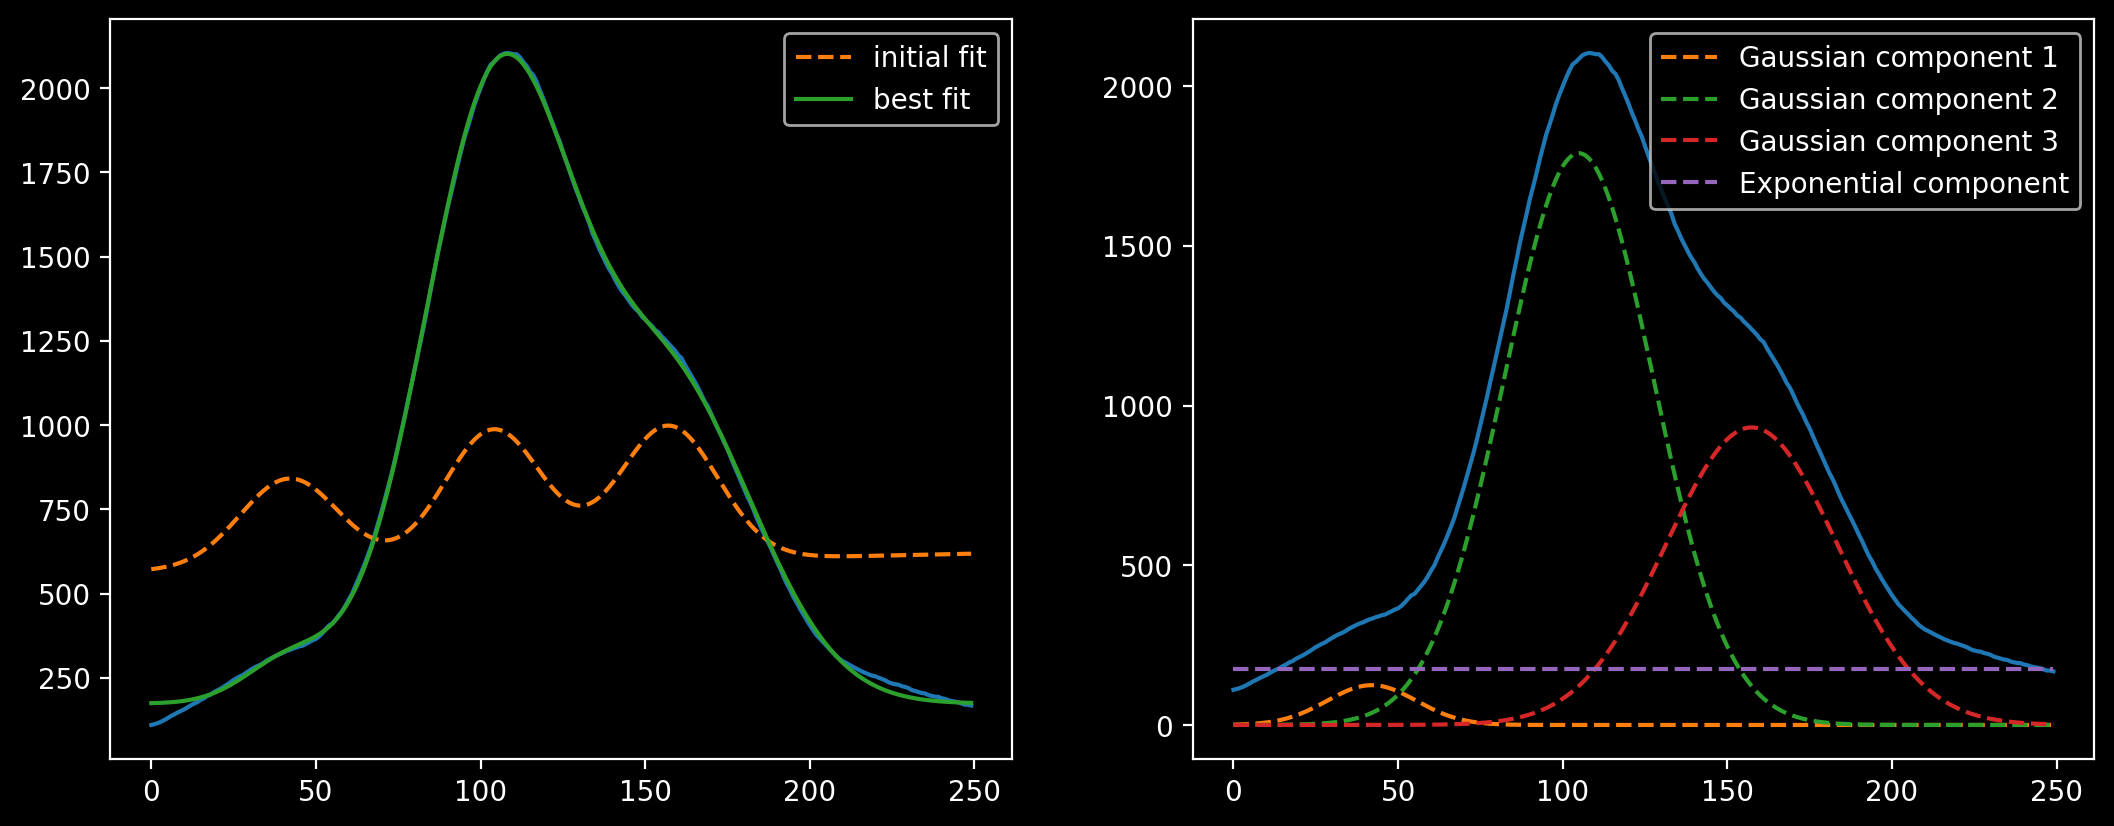

In [24]:
y = wx_o2
x = np.arange(0, len(y))
exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(value=42, min=22, max=42)
pars['g1_sigma'].set(value=15, min=3)
pars['g1_amplitude'].set(value=10000, min=10)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=104,    min=84, max=124)
pars['g2_sigma'].set(value=15, min=3)
pars['g2_amplitude'].set(value=15000, min=10)

gauss3 =   GaussianModel(prefix='g3_')
pars.update(gauss3.make_params())

pars['g3_center'].set(value=157, min=137, max=177)
pars['g3_sigma'].set(value=15, min=3)
pars['g3_amplitude'].set(value=15000, min=10)

mod = gauss1 + gauss2 + gauss3 + exp_mod

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y)
axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], '--', label='Gaussian component 2')
axes[1].plot(x, comps['g3_'], '--', label='Gaussian component 3')
axes[1].plot(x, comps['exp_'], '--', label='Exponential component')
axes[1].legend()

plt.show()

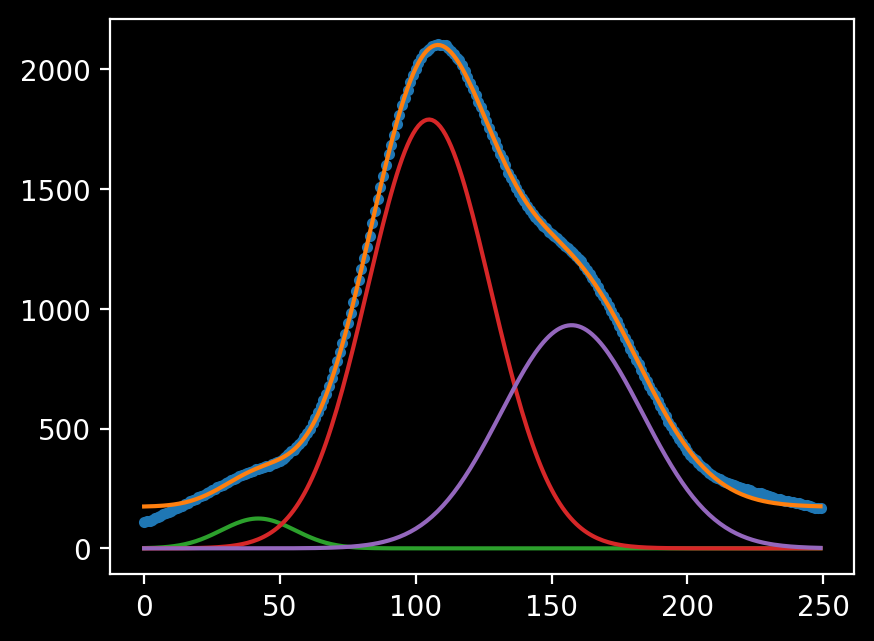

In [25]:
plt.plot(x, y, '.')
plt.plot(x, out.best_fit, '-')
plt.plot(x, comps['g1_'], '-')
plt.plot(x, comps['g2_'], '-')
plt.plot(x, comps['g3_'], '-')
plt.show()

In [28]:
print("{:.2f}".format(out.best_values['g1_amplitude']))
print("{:.2f}".format(out.best_values['g2_amplitude']))
print("{:.2f}".format(out.best_values['g3_amplitude']))
print("{:.2f}".format(out.best_values['g1_center']))
print("{:.2f}".format(out.best_values['g2_center']))
print("{:.2f}".format(out.best_values['g3_center']))


print("{:.2f}".format(out.best_values['g1_center']+start))
print("{:.2f}".format(out.best_values['g2_center']+start))
print("{:.2f}".format(out.best_values['g3_center']+start))
                

4246.08
101588.67
60820.96
42.00
104.88
157.38
3242.00
3304.88
3357.38


In [9]:
print(out.best_values)

{'exp_decay': 4127607757.370634, 'exp_amplitude': 173.59418007199326, 'g3_sigma': 26.11753867924496, 'g3_center': 157.24033927458237, 'g3_amplitude': 61156.756600986344, 'g2_sigma': 22.585196599409162, 'g2_center': 104.82738067000058, 'g2_amplitude': 101213.9238197475, 'g1_sigma': 13.763428810167738, 'g1_center': 42.33624858966573, 'g1_amplitude': 4307.58082586267}


In [19]:
sum(comps['g1_'])

4460.610029989063

In [20]:
sum(comps['g2_'])

98899.37088871785

In [21]:
sum(comps['g3_'])

64157.048846436846

In [22]:
c=0
d=0
for asd in range(len(wx_o2)):
    
    if wx_o2[c]>=max(wx_o2)/2:
        d=c
        break
    c=c+1


In [23]:
e=0
c=len(wx_o2)-1 
for asd in range(len(wx_o2)):
    if wx_o2[c]>=max(wx_o2)/2:
        e=(c-d)/2
        break
    c=c-1


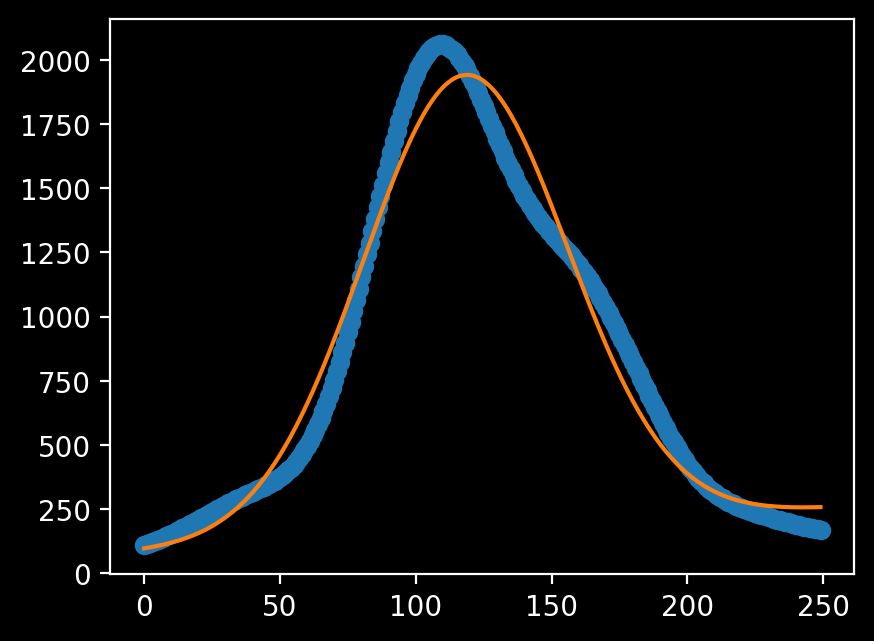

209657.0

In [24]:

def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))


def line(x, slope, intercept):
    """a line"""
    return slope*x + intercept


mod = Model(gaussian) + Model(line)
pars = mod.make_params(amp=max(wx_o2)*e, cen=80, wid=e, slope=0, intercept=1)

result = mod.fit(y, pars, x=x)

plt.plot(x, y, 'o')
plt.plot(x, result.best_fit, '-')
plt.show()
round(sum(result.best_fit))

In [13]:
print(result.fit_report())

NameError: name 'result' is not defined